Loaded 20000 images across 10 classes.


C:\Users\apput\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.6227 - loss: 1.0926 - val_accuracy: 0.9967 - val_loss: 0.0147
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.9731 - loss: 0.0814 - val_accuracy: 0.9998 - val_loss: 0.0031
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.9852 - loss: 0.0449 - val_accuracy: 0.9995 - val_loss: 0.0014
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.9917 - loss: 0.0254 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.9901 - loss: 0.0316 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.9921 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 3.1617e-04
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.9912 - loss: 0.0285 - val_accuracy: 1.0000 - val_loss: 4.7033e-04
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.9947 - loss: 0

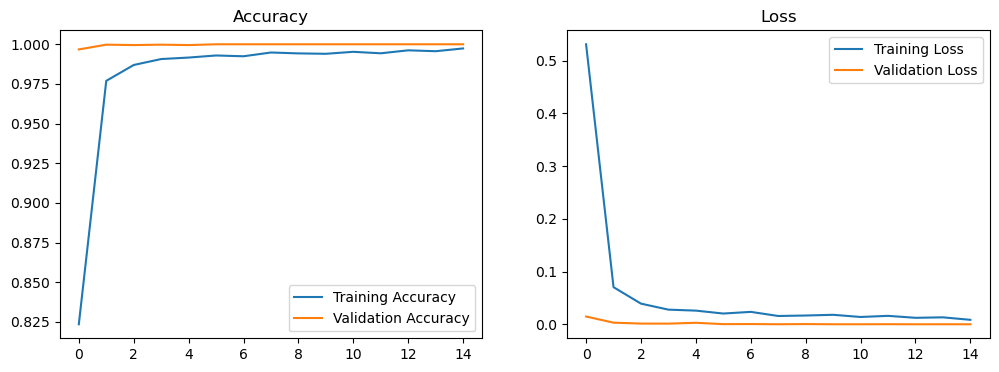

Number of images loaded: 20000
Number of labels loaded: 20000
Classes: ['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt

# Set the base directory of the dataset
base_dir = r"C:\Users\apput\Downloads\archive (1)\leapGestRecog\leapGestRecog"

# Load and preprocess the dataset
def load_data(base_dir, image_size=(64, 64)):
    images = []
    labels = []

    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"Dataset directory not found: {base_dir}")

    for root, _, files in os.walk(base_dir):  # Recursively traverse all subdirectories
        if files:  # Process only if there are files in the directory
            label = os.path.basename(root)  # Use the folder name as the label
            for file in files:
                file_path = os.path.join(root, file)
                if file.lower().endswith(".png"):  # Check for PNG files
                    try:
                        # Load image and resize
                        img = Image.open(file_path).convert('L')  # Convert to grayscale
                        img = img.resize(image_size)
                        images.append(np.array(img))
                        labels.append(label)  # Use folder name as label
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")

    if len(images) == 0 or len(labels) == 0:
        raise ValueError("No valid images or labels found. Check the dataset path and structure.")
    
    print(f"Loaded {len(images)} images across {len(set(labels))} classes.")
    return np.array(images), np.array(labels)

# Load dataset
image_size = (64, 64)
images, labels = load_data(base_dir, image_size=image_size)

# Normalize images and encode labels
images = images / 255.0  # Normalize pixel values to [0, 1]
images = images.reshape(-1, image_size[0], image_size[1], 1)  # Add channel dimension
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)

# Create the CNN model
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Initialize the model
input_shape = (image_size[0], image_size[1], 1)
num_classes = len(label_encoder.classes_)
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save("hand_gesture_model.keras")


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Summary of dataset
print(f"Number of images loaded: {len(images)}")
print(f"Number of labels loaded: {len(labels)}")
print(f"Classes: {label_encoder.classes_}")


In [5]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Load the trained model
model = load_model("hand_gesture_model.keras")

# Define the function to predict gestures
def predict_gesture(image_path, model, label_encoder, image_size=(64, 64)):
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert('L').resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize
        img_array = img_array.reshape(1, image_size[0], image_size[1], 1)  # Add batch dimension
        
        # Make predictions
        prediction = model.predict(img_array)
        class_index = np.argmax(prediction)
        class_label = label_encoder.inverse_transform([class_index])[0]
        return class_label
    except FileNotFoundError:
        return f"Error: File not found at {image_path}"
    except Exception as e:
        return f"Error processing image: {e}"

# Correct the path to an actual image
image_path = r"C:\Users\apput\Downloads\archive (1)\leapGestRecog\leapGestRecog\00\01_palm\frame_00_01_0001.png"

# Call the function
result = predict_gesture(image_path, model, label_encoder)
print("Predicted Gesture:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted Gesture: 01_palm
